<a href="https://colab.research.google.com/github/Jum-eng/MLP-Cockroach-Optimization-Algorithm-for-HDP-using-Cleveland-dataset/blob/main/Cuckoo_search_using_cleveland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Install required library
```



In [ ]:
# Install required library
!pip install pyMetaheuristic
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.9 MB/s eta 0:00:00


# Importing libraries

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from pyMetaheuristic.algorithm import cuckoo_search

import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# Step 2: Load and Preprocess Heart Disease Dataset
df = pd.read_csv('/content/Heart_disease_cleveland_new.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [ ]:
# Checking for missing values
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,2.158416,0.960126,0.0,2.0,2.0,3.0,3.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
df.shape

(303, 14)

In [ ]:
# Split features and label
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def build_mlp_model(input_shape, learning_rate=0.001, neurons_layer1=64, neurons_layer2=32, dropout1=0.3, dropout2=0.3):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(input_shape,)))

    # First Dense Layer
    model.add(Dense(neurons_layer1, activation='relu'))
    model.add(Dropout(dropout1))

    # Second Dense Layer
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dropout(dropout2))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_mlp_model(input_shape=13)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Define Hyperparameter Bounds
param_bounds = {
    'learning_rate': [0.0001, 0.01],
    'neurons_layer1': [32, 128],
    'neurons_layer2': [16, 64],
    'dropout1': [0.2, 0.5],
    'dropout2': [0.2, 0.5],
    'batch_size': [16, 64]
}
param_names = list(param_bounds.keys())
lb = [v[0] for v in param_bounds.values()]
ub = [v[1] for v in param_bounds.values()]

In [ ]:
#Step 5: Fitness Function for Dragonfly Algorithm
def fitness_cs(hyperparams, X_train, y_train, X_val, y_val):
    lr, n1, n2, d1, d2, batch_size = hyperparams
    n1, n2 = int(n1), int(n2)
    batch_size = int(batch_size)

    try:
        model = build_mlp_model(input_shape=X_train.shape[1],
                                learning_rate=lr,
                                neurons_layer1=n1,
                                neurons_layer2=n2,
                                dropout1=d1,
                                dropout2=d2)

        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=10,
                            batch_size=batch_size,
                            verbose=0)

        val_acc = history.history['val_accuracy'][-1]
        return -val_acc
    except:
        return 1.0

In [ ]:
# Step 6: Run Cuckoo Algorithm
parameters = {
    'birds': 10,  # Number of particles
    'min_values': tuple(lb),
    'max_values': tuple(ub),
    'iterations': 20,
    'verbose': True,
    'start_init': None,
    'target_value': None
}

# Create a wrapper function for the fitness function
def wrapper_fitness_cs(hyperparams):
    return fitness_cs(hyperparams, X_train, y_train, X_val, y_val)

# CS - Algorithm

cs = cuckoo_search(target_function=wrapper_fitness_cs, **parameters)
best_solution = cs[:-1]
best_score = -cs[-1]  # Convert back to positive accuracy

Iteration =  0  f(x) =  -0.8444444537162781
Iteration =  1  f(x) =  -0.8666666746139526
Iteration =  2  f(x) =  -0.8666666746139526
Iteration =  3  f(x) =  -0.8666666746139526
Iteration =  4  f(x) =  -0.8888888955116272
Iteration =  5  f(x) =  -0.8888888955116272
Iteration =  6  f(x) =  -0.8888888955116272
Iteration =  7  f(x) =  -0.8888888955116272
Iteration =  8  f(x) =  -0.8888888955116272
Iteration =  9  f(x) =  -0.8888888955116272
Iteration =  10  f(x) =  -0.8888888955116272
Iteration =  11  f(x) =  -0.8888888955116272
Iteration =  12  f(x) =  -0.8888888955116272
Iteration =  13  f(x) =  -0.8888888955116272
Iteration =  14  f(x) =  -0.8888888955116272
Iteration =  15  f(x) =  -0.8888888955116272
Iteration =  16  f(x) =  -0.8888888955116272
Iteration =  17  f(x) =  -0.8888888955116272
Iteration =  18  f(x) =  -0.8888888955116272
Iteration =  19  f(x) =  -0.8888888955116272
Iteration =  20  f(x) =  -0.8888888955116272


In [ ]:
# Step 7: Format Best Hyperparameters
best_params = dict(zip(param_names, best_solution))
best_params['neurons_layer1'] = int(best_params['neurons_layer1'])
best_params['neurons_layer2'] = int(best_params['neurons_layer2'])
best_params['batch_size'] = int(best_params['batch_size'])

print(f"\n Best Validation Accuracy: {best_score:.4f}")
print(f" Best Hyperparameters: {best_params}")


 Best Validation Accuracy: 0.8889
 Best Hyperparameters: {'learning_rate': np.float64(0.001292780651085222), 'neurons_layer1': 57, 'neurons_layer2': 30, 'dropout1': np.float64(0.3818357506647738), 'dropout2': np.float64(0.306001157397261), 'batch_size': 46}


In [ ]:
final_model = build_mlp_model(
    input_shape=X_train.shape[1],
    learning_rate=best_params['learning_rate'],
    neurons_layer1=best_params['neurons_layer1'],
    neurons_layer2=best_params['neurons_layer2'],
    dropout1=best_params['dropout1'],
    dropout2=best_params['dropout2']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train final model with best parameters
history = final_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                epochs=75, batch_size=best_params['batch_size'], callbacks=[early_stop], verbose=1)

# You can evaluate the final model on validation data
val_loss, val_accuracy = final_model.evaluate(X_val, y_val)
print(f"\n Final Model Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4842 - loss: 0.7853 - val_accuracy: 0.5778 - val_loss: 0.6549
Epoch 2/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5633 - loss: 0.6934 - val_accuracy: 0.6889 - val_loss: 0.5927
Epoch 3/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6219 - loss: 0.6493 - val_accuracy: 0.8222 - val_loss: 0.5447
Epoch 4/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6758 - loss: 0.5917 - val_accuracy: 0.8444 - val_loss: 0.5069
Epoch 5/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7539 - loss: 0.5377 - val_accuracy: 0.8222 - val_loss: 0.4757
Epoch 6/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7407 - loss: 0.5101 - val_accuracy: 0.8000 - val_loss: 0.4498
Epoch 7/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7718 - loss: 0.4799 - val_accuracy: 0.8000 - val_loss: 0.4287
Epoch 8/75
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7602 - loss: 0.4859 - val_accuracy: 0.8000 - val_loss: 0.4121


In [ ]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.8696


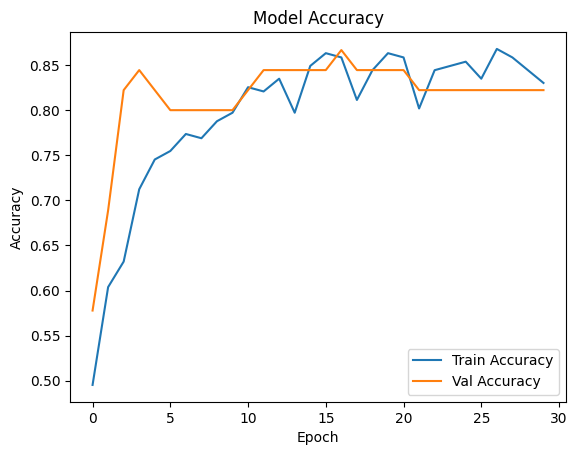

In [ ]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

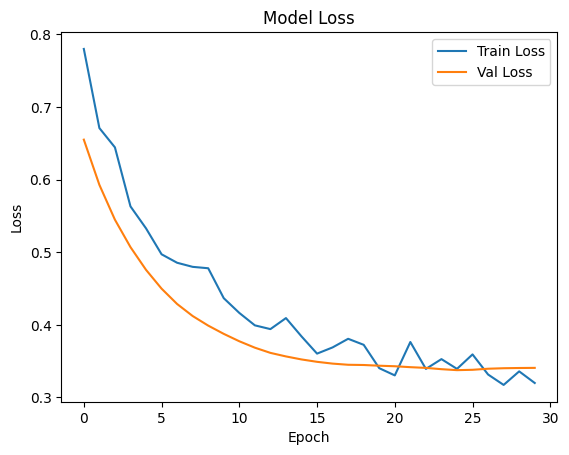

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


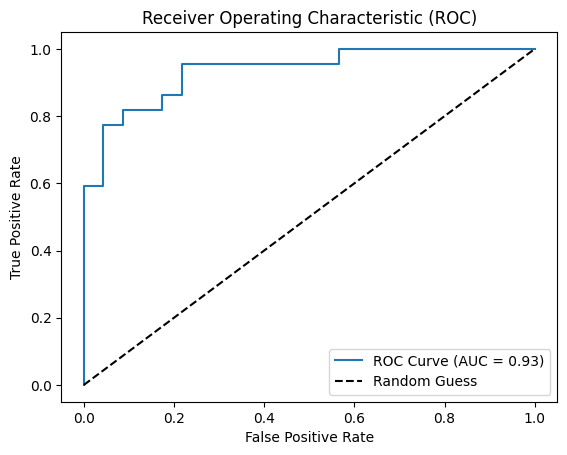

In [ ]:
y_pred_prob = final_model.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

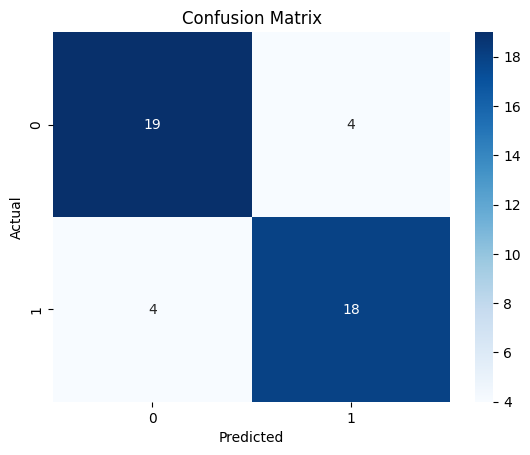

In [ ]:
y_pred = (y_pred_prob > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


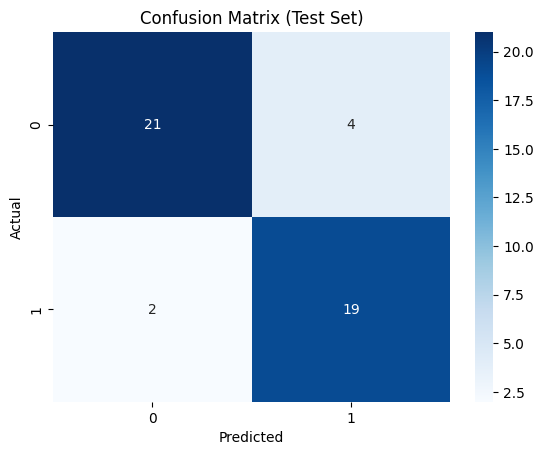

In [ ]:
y_pred_prob_test = final_model.predict(X_test)
y_pred_test = (y_pred_prob_test > 0.5).astype(int)
cm_test = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_pred_prob_test = final_model.predict(X_test)
y_pred_test = (y_pred_prob_test > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob_test):.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[21  4]
 [ 2 19]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.83      0.90      0.86        21

    accuracy                           0.87        46
   macro avg       0.87      0.87      0.87        46
weighted avg       0.87      0.87      0.87        46

ROC-AUC: 0.8876
